In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import humanize
import plotly.express as px
import warnings
import pymongo
import os

In [2]:
sns.set_style('darkgrid')
plt.rcParams['figure.dpi'] = 80
warnings.filterwarnings('ignore')

In [3]:
client = pymongo.MongoClient(os.getenv('MONGO_URI'))
db = client[os.getenv('MONGO_DATABASE')]
collection = db['scrapy_bogota_apartments_processed']

apartments = pd.DataFrame(list(collection.find()))
apartments = apartments.drop(columns=['_id'], axis=1)
apartments = apartments.loc[(apartments['tipo_operacion'] == 'VENTA') & (apartments['coords_modified'] == False)]

chapinero = apartments.loc[apartments['localidad'] == 'CHAPINERO']
chapinero.head()

codigo tipo_propiedad tipo_operacion  precio_venta  area  habitaciones  \
14   3052285    APARTAMENTO          VENTA   381000000.0  47.0           2.0   
47   4290935    APARTAMENTO          VENTA   198411512.0  29.0           1.0   
59   4341693    APARTAMENTO          VENTA   540000000.0  70.0           2.0   
104  4203427    APARTAMENTO          VENTA   371600000.0  55.0           1.0   
352  4316327    APARTAMENTO          VENTA   440000000.0  56.0           1.0   

     banos  administracion  parqueaderos      sector  ...  vigilancia  \
14     1.0        438000.0           1.0  CHICO LAGO  ...         0.0   
47     1.0        150000.0           0.0   CHAPINERO  ...         0.0   
59     2.0        756000.0           2.0  CHICO LAGO  ...         0.0   
104    1.0        611000.0           1.0  CHICO LAGO  ...         0.0   
352    2.0        776999.0           0.0  CHICO LAGO  ...         0.0   

    coords_modified  localidad                       barrio  \
14            False  CHAPINERO  S.C. CHICO NORTE III SECTOR   
47            False  CHAPINERO       S.C. CHAPINERO CENTRAL   
59            False  CHAPINERO  S.C. CHICO NORTE III SECTOR   
104           False  CHAPINERO  S.C. CHICO NORTE III SECTOR   
352           False  CHAPINERO  S.C. CHICO NORTE III SECTOR   

          estacion_tm_cercana distancia_estacion_tm_m is_cerca_estacion_tm  \
14   Calle 100 - Marketmedios                  901.98                    0   
47                   Calle 57                  287.87                    1   
59   Calle 100 - Marketmedios                  231.12                    1   
104  Calle 100 - Marketmedios                  880.74                    0   
352  Calle 100 - Marketmedios                  240.13                    1   

                                        parque_cercano distancia_parque_m  \
14               PARQUE ZONAL CANAL EL VIRREY EL CHICO            1128.83   
47                   PARQUE ZONAL GUSTAVO URIBE BOTERO            1447.99   
59   PARQUE VECINAL URBANIZACIÓN NORMANDIA I II II ...             821.82   
104  PARQUE VECINAL URBANIZACIÓN NORMANDIA I II II ...            1148.59   
352  PARQUE VECINAL URBANIZACIÓN NORMANDIA I II II ...             862.08   

    is_cerca_parque  
14                0  
47                0  
59                0  
104               0  
352               0  

[5 rows x 45 columns]

In [4]:
# apartments = pd.read_csv('../../data/processed/apartments.csv', low_memory=False)
# chapinero =  apartments[(apartments['tipo_operacion'] == 'VENTA') & (apartments['localidad'] == 'CHAPINERO') & (apartments['coords_modified'] == False)]
# chapinero = chapinero.drop(columns=['precio_arriendo'])
# chapinero.head()

In [5]:
chapinero.datetime = pd.to_datetime(chapinero.datetime)
chapinero['last_viewed'] = pd.to_datetime(chapinero['last_view'])

In [6]:
chapinero.shape

(7087, 46)

In [7]:
chapinero.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7087 entries, 14 to 42993
Data columns (total 46 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   codigo                   7087 non-null   object        
 1   tipo_propiedad           7087 non-null   object        
 2   tipo_operacion           7087 non-null   object        
 3   precio_venta             7087 non-null   float64       
 4   area                     7087 non-null   float64       
 5   habitaciones             7087 non-null   float64       
 6   banos                    7087 non-null   float64       
 7   administracion           6448 non-null   float64       
 8   parqueaderos             7087 non-null   float64       
 9   sector                   6899 non-null   object        
 10  estrato                  7086 non-null   float64       
 11  antiguedad               7082 non-null   object        
 12  latitud                  7087 non-nul

In [8]:
chapinero.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta', 'area',
       'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector',
       'estrato', 'antiguedad', 'latitud', 'longitud', 'direccion',
       'descripcion', 'website', 'last_view', 'datetime', 'url', 'timeline',
       'estado', 'compañia', 'precio_arriendo', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'piscina', 'salon_comunal', 'terraza', 'vigilancia',
       'coords_modified', 'localidad', 'barrio', 'estacion_tm_cercana',
       'distancia_estacion_tm_m', 'is_cerca_estacion_tm', 'parque_cercano',
       'distancia_parque_m', 'is_cerca_parque', 'last_viewed'],
      dtype='object')

In [9]:
def format_tick_humanize(value, tick_number):
    return humanize.intword(value)

# Eliminar outliers

Eliminamos los precios que son outliers

In [10]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    chapinero,
    x='precio_venta',
    width=.5,
    palette='Set3',
)

plt.title('Precio de venta de apartamentos en Chapinero')
plt.xlabel('Precio de venta')
plt.show()

In [11]:
Q1 = chapinero['precio_venta'].quantile(0.25)
Q3 = chapinero['precio_venta'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - (1.5 * IQR)
if lower < 0:
    lower = Q1 - (0.5 * IQR)
upper = Q3 + (1.5 * IQR)

outliers = chapinero[(chapinero['precio_venta'] < lower) | (chapinero['precio_venta'] > upper)]
outliers.shape

(335, 46)

In [12]:
chapinero = chapinero[(chapinero['precio_venta'] > lower) & (chapinero['precio_venta'] < upper)]
chapinero.shape

(6741, 46)

# Analisis Univariado

## Area (m2)

### Eliminar outliers

In [13]:
# eliminar area igual a 0

chapinero = chapinero[chapinero['area'] > 0]

Eliminamos las areas (m2) que son outliers

In [14]:
Q1 = chapinero['area'].quantile(0.25)
Q3 = chapinero['area'].quantile(0.75)

IQR = Q3 - Q1

lower = Q1 - (1.5 * IQR)
upper = Q3 + (1.5 * IQR)

outliers = chapinero[(chapinero['area'] < lower) | (chapinero['area'] > upper)]
outliers.shape

(75, 46)

In [15]:
chapinero = chapinero[(chapinero['area'] > lower) & (chapinero['area'] < upper)]
chapinero.shape

(6652, 46)

### Analisis

In [16]:
chapinero.area.describe().apply(lambda x: humanize.intcomma(x)).to_frame().T

count                mean                std  min    25%    50%  \
area  6,652.0  179.46872970535182  89.65275294537815  1.0  110.0  170.0   

        75%    max  
area  240.0  444.0

In [17]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    data=chapinero,
    x='area',
    width=.3,
    palette='Set3',
    linewidth=.8,
)

plt.title('Área de apartamentos en Chapinero')
plt.xlabel('Área (m2)')
plt.show()

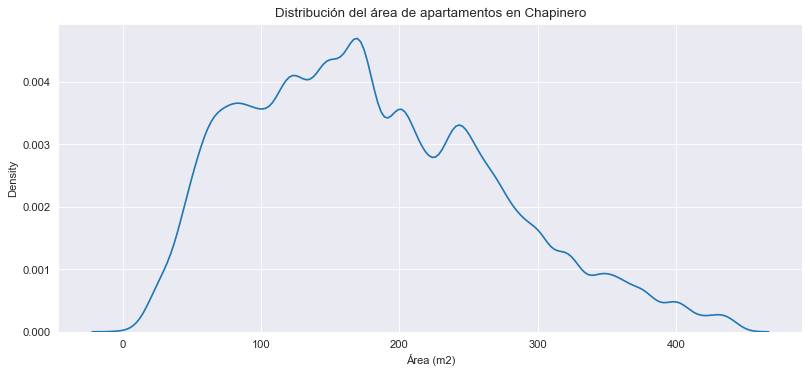

In [18]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='area',
    bw_adjust=.5,
)

plt.title('Distribución del área de apartamentos en Chapinero')
plt.xlabel('Área (m2)')
plt.show()

### Cercania a Transmilenio

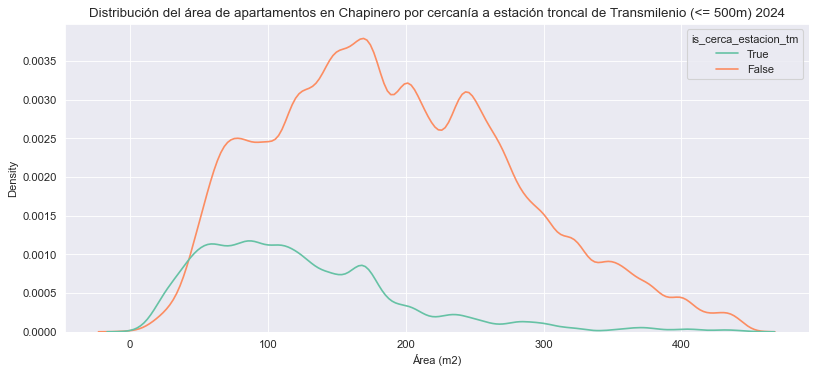

In [19]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='area',
    bw_adjust=.5,
    hue='is_cerca_estacion_tm',
    palette='Set2',
    hue_order=[True, False],
)

plt.title('Distribución del área de apartamentos en Chapinero por cercanía a estación troncal de Transmilenio (<= 500m) 2024')
plt.xlabel('Área (m2)')
plt.show()

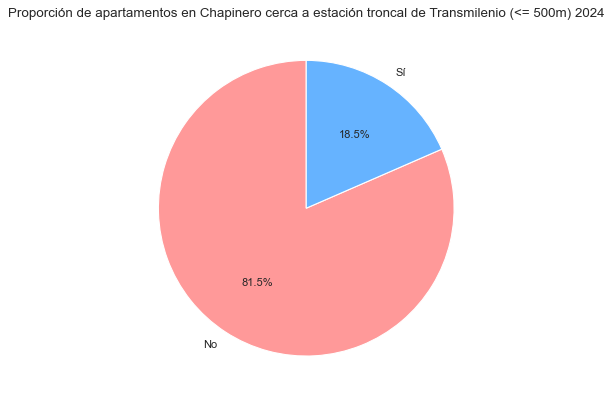

In [67]:
# pie chart de apartamentos cerca a estación troncal de Transmilenio

plt.figure(figsize=(6, 6))

chapinero['is_cerca_estacion_tm'].value_counts().plot.pie(
    autopct='%1.1f%%',
    startangle=90,
    colors=['#ff9999', '#66b3ff'],
    labels=['No', 'Sí'],
)

plt.title('Proporción de apartamentos en Chapinero cerca a estación troncal de Transmilenio (<= 500m) 2024')
plt.ylabel('')

plt.show()

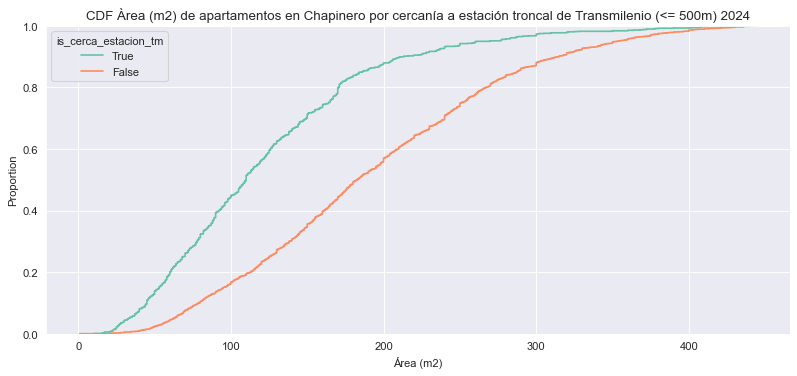

In [21]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='area',
    hue='is_cerca_estacion_tm',
    palette='Set2',
    hue_order=[True, False],
)

plt.title('CDF Àrea (m2) de apartamentos en Chapinero por cercanía a estación troncal de Transmilenio (<= 500m) 2024')
plt.xlabel('Área (m2)')
plt.show()


### Estrato

In [22]:
chapinero.groupby('estrato')['area'].describe().applymap(lambda x: round(x, 1))

count   mean    std    min    25%    50%    75%    max
estrato                                                         
0.0         4.0  237.5  126.2  108.0  159.0  221.0  299.5  400.0
1.0        12.0  240.7   68.7  125.0  205.2  235.5  271.9  361.0
2.0         7.0  103.3  105.1   27.4   41.0   57.0  116.0  325.0
3.0       103.0   62.8   40.3   15.5   30.0   56.0   72.5  180.0
4.0       528.0   95.5   61.5   17.7   52.0   76.3  118.0  344.0
5.0       683.0  136.0   70.4    1.0   81.1  124.0  171.8  420.0
6.0      5314.0  195.6   86.6   10.0  130.0  185.0  254.0  444.0

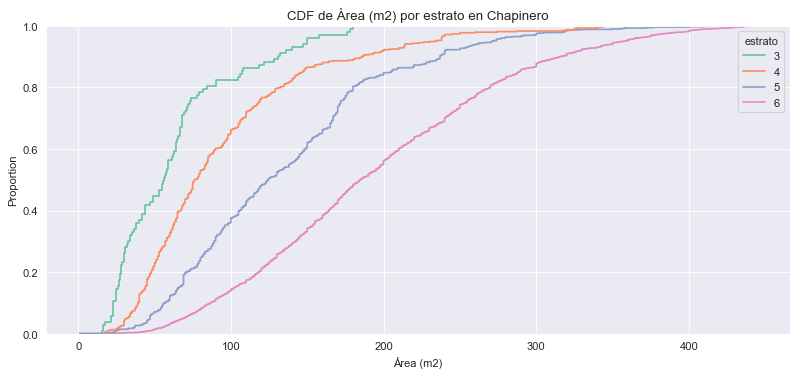

In [23]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='area',
    hue='estrato',
    palette='Set2',
    hue_order=[3, 4, 5, 6],
)

plt.title('CDF de Àrea (m2) por estrato en Chapinero')
plt.xlabel('Área (m2)')
plt.show()

### Antiguedad

In [24]:
chapinero.groupby('antiguedad')['area'].describe().applymap(lambda x: round(x, 1))

count   mean    std   min    25%    50%    75%    max
antiguedad                                                                
EN CONSTRUCCION       13.0   42.8   20.8  21.3   27.4   35.8   55.5   88.4
ENTRE 0 Y 5 ANOS     930.0  143.2   79.3  13.0   77.0  138.5  203.8  393.0
ENTRE 10 Y 20 ANOS  1619.0  178.6   90.3   1.0  108.0  166.0  242.0  441.0
ENTRE 5 Y 10 ANOS    945.0  166.3   86.5  20.0   95.0  155.0  228.0  444.0
MAS DE 20 ANOS      2828.0  194.7   88.3  10.0  128.0  184.0  251.5  441.0
PARA ESTRENAR          4.0  129.7  104.3  27.4   49.6  123.3  203.4  244.9
REMODELADO           303.0  203.4   94.8  39.0  136.6  195.0  265.5  440.0
SOBRE PLANOS           5.0   61.2   20.7  30.3   62.4   62.4   62.4   88.6

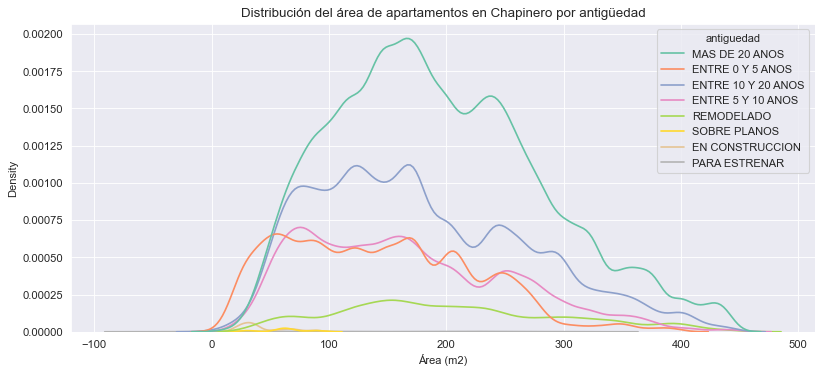

In [25]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='area',
    bw_adjust=.5,
    hue='antiguedad',
    palette='Set2',
)

plt.title('Distribución del área de apartamentos en Chapinero por antigüedad')
plt.xlabel('Área (m2)')
plt.show()

In [26]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='area',
    hue='antiguedad',
    palette='Set2',
)

plt.title('CDF de Àrea por antiguedad en Chapinero')
plt.xlabel('Área (m2)')
plt.show()

Lo apartamentos mas recientes tienden a tener un Àrea menor que los mas antiguos

### Estacion de TM Cercana

In [27]:
estacion_tm_cercana = chapinero[chapinero['is_cerca_estacion_tm'] == True]
estacion_tm_cercana_stats = estacion_tm_cercana.groupby('estacion_tm_cercana')['area'].describe().applymap(lambda x: round(x, 1)).sort_values(by='mean', ascending=False)
estacion_tm_cercana_stats

count   mean    std   min    25%    50%  \
estacion_tm_cercana                                                       
Héroes                           25.0  197.0  102.9  40.0  130.0  176.0   
Virrey                          266.0  158.5   81.5  10.0   97.7  134.5   
Calle 85                        273.0  135.2   60.7  24.3   88.4  134.0   
Calle 100 - Marketmedios        351.0  123.5   66.7  17.0   77.0  113.0   
Calle 76 - San Felipe            26.0  113.6   88.0  22.4   50.5   95.1   
Flores – Areandina               27.0   96.9   47.0  21.3   56.0  108.8   
Calle 72                         18.0   79.4   52.6  34.0   49.0   72.7   
Marly                            53.0   76.6   51.1  25.0   45.0   61.0   
Calle 63                         60.0   75.4   43.0  15.5   38.0   68.0   
Calle 45 - American School Way   45.0   63.2   31.1  27.0   39.8   55.0   
Calle 57                         65.0   62.7   38.1  21.5   30.0   58.0   
AV. 39                           19.0   57.8   18.9  40.0   46.6   51.0   

                                  75%    max  
estacion_tm_cercana                           
Héroes                          240.0  441.0  
Virrey                          203.8  434.4  
Calle 85                        170.0  427.0  
Calle 100 - Marketmedios        154.0  430.0  
Calle 76 - San Felipe           136.3  321.2  
Flores – Areandina              123.9  214.0  
Calle 72                         77.8  259.8  
Marly                            94.4  325.0  
Calle 63                        108.5  180.0  
Calle 45 - American School Way   84.2  138.0  
Calle 57                         79.0  157.5  
AV. 39                           64.9  110.3

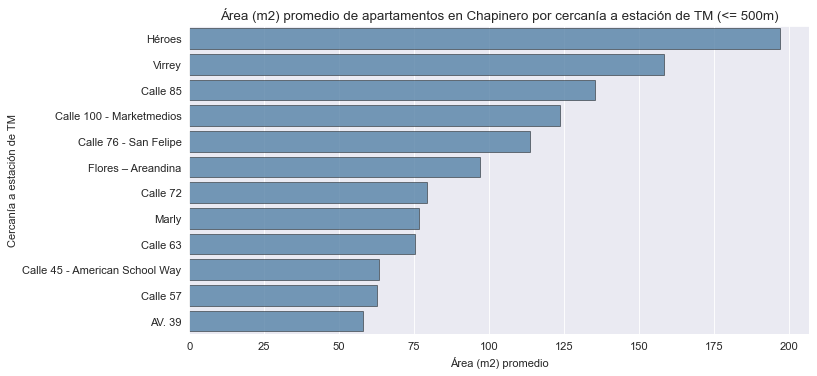

In [28]:
plt.figure(figsize=(10, 5))

sns.barplot(
    estacion_tm_cercana_stats,
    y=estacion_tm_cercana_stats.index,
    x='mean',
    # palette='Set2',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Área (m2) promedio de apartamentos en Chapinero por cercanía a estación de TM (<= 500m)')
plt.xlabel('Área (m2) promedio')
plt.ylabel('Cercanía a estación de TM')
plt.show()

In [29]:
estacion_tm_cercana_stats = estacion_tm_cercana.groupby('estacion_tm_cercana')['area'].describe().applymap(lambda x: round(x, 1)).sort_values(by='50%', ascending=False)

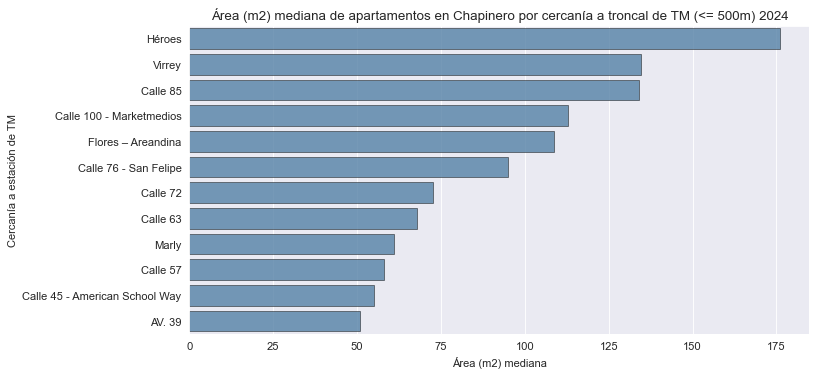

In [30]:
plt.figure(figsize=(10, 5))

sns.barplot(
    estacion_tm_cercana_stats,
    y=estacion_tm_cercana_stats.index,
    x='50%',
    # palette='Set2',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Área (m2) mediana de apartamentos en Chapinero por cercanía a troncal de TM (<= 500m) 2024')
plt.xlabel('Área (m2) mediana')
plt.ylabel('Cercanía a estación de TM')
plt.show()

<Figure size 800x400 with 0 Axes>

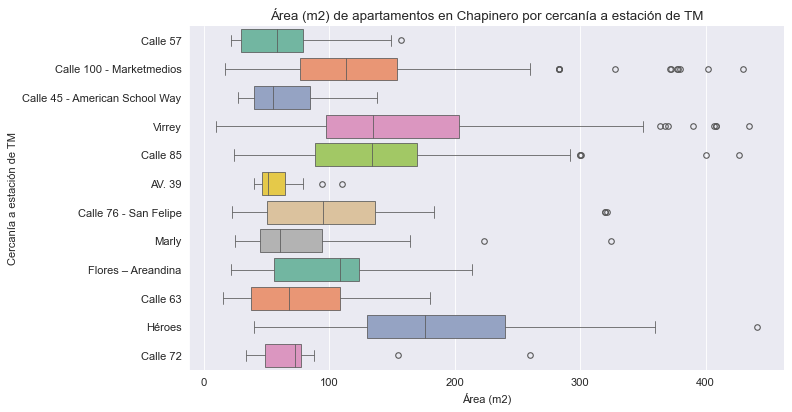

In [31]:
plt.figure(figsize=(10, 5))

sns.catplot(
    data=estacion_tm_cercana,
    x='area',
    y='estacion_tm_cercana',
    kind='box',
    height=5,
    aspect=2,
    palette='Set2',
    orient='h',
    linewidth=.7,
)

plt.title('Área (m2) de apartamentos en Chapinero por cercanía a estación de TM')
plt.xlabel('Área (m2)')
plt.ylabel('Cercanía a estación de TM')
plt.show()

## Precio de venta

In [32]:
mapbox_access_token = os.getenv('MAPBOX_TOKEN')
px.set_mapbox_access_token(mapbox_access_token)

fig = px.scatter_mapbox(
    chapinero,
    lat='latitud',
    lon='longitud',
    color='precio_venta',
    size='area',
    color_continuous_scale=px.colors.cyclical.IceFire,
    size_max=15,
    zoom=11,
    # mapbox_style='open-street-map',
    # mapbox_style='dark',
    title='Precio de venta y área de apartamentos en Chapinero',
    hover_name='barrio',
    hover_data=['area', 'precio_venta', 'estrato', 'antiguedad', 'is_cerca_estacion_tm', 'estacion_tm_cercana'],
)

fig.update_layout(
    margin=dict(l=0, r=0, t=50, b=0),
    coloraxis_colorbar=dict(
        title='Precio de venta',
        tickformat='s',
    ),
    mapbox=dict(
        accesstoken=mapbox_access_token,
        style='basic',
    ),
    
)

# save plot
fig.write_html('../../html/precio_venta_area_chapinero.html')

fig.show()

In [33]:
chapinero.precio_venta.describe().apply(lambda x: humanize.intword(x)).to_frame().T

count         mean            std            min  \
precio_venta  6.7 thousand  1.6 billion  974.0 million  155.0 million   

                        25%          50%          75%          max  
precio_venta  835.0 million  1.4 billion  2.2 billion  4.5 billion

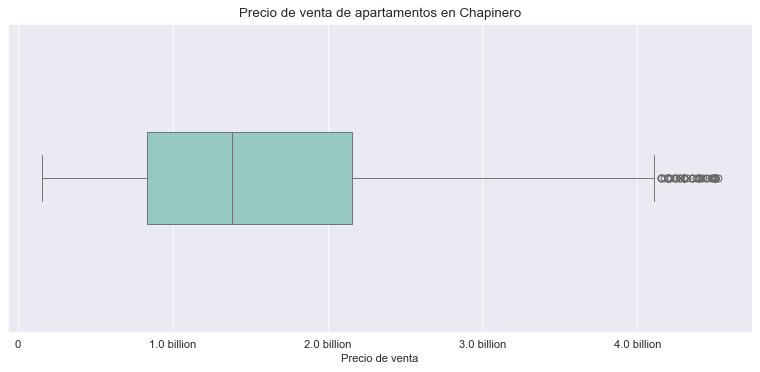

In [34]:
plt.figure(figsize=(12, 5))

sns.boxplot(
    chapinero,
    x='precio_venta',
    width=.3,
    palette='Set3',
    linewidth=.8,
)

plt.title('Precio de venta de apartamentos en Chapinero')
plt.xlabel('Precio de venta')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [35]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='precio_venta',
    bw_adjust=.5,
)

plt.title('Distibución de precios de venta de apartamentos en Chapinero')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [36]:
stat, p = stats.normaltest(chapinero['precio_venta'])
print('stat=%.3f, p=%.3f' % (stat, p))

stat=720.080, p=0.000


In [37]:
if p > 0.05:
    print('Probably Gaussian')
else:
    print('Probably not Gaussian')

Probably not Gaussian


### Barrios

In [38]:
top_barrios = chapinero.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('precio_venta', 'mean'),
    median=('precio_venta', 'median'),
    std=('precio_venta', 'std'),
)

# escoger los que tienen más de 20 registros para que sea más representativo
top_barrios_mean = top_barrios[top_barrios['count'] > 22].sort_values('mean', ascending=False).head(10)
top_barrios_mean.applymap(lambda x: humanize.intword(x))

count         mean       median            std
barrio                                                                  
LA CABRERA                  352  2.4 billion  2.2 billion  967.2 million
S.C. EL RETIRO              160  2.1 billion  1.9 billion    1.0 billion
CHICO ORIENTAL              160  2.1 billion  1.8 billion    1.1 billion
CHICO ALTO                  105  2.1 billion  1.9 billion  784.3 million
PINAR ALTO - PINAR II        30  2.0 billion  2.2 billion  803.1 million
LOS ROSALES                 542  1.9 billion  1.7 billion  979.4 million
S.C. BELLAVISTA             465  1.9 billion  1.7 billion  895.9 million
EL REFUGIO                  254  1.9 billion  1.7 billion  858.2 million
S.C. EL NOGAL               274  1.9 billion  1.7 billion  879.7 million
BOSQUE EL RETIRO I SECTOR   154  1.8 billion  1.6 billion  961.4 million

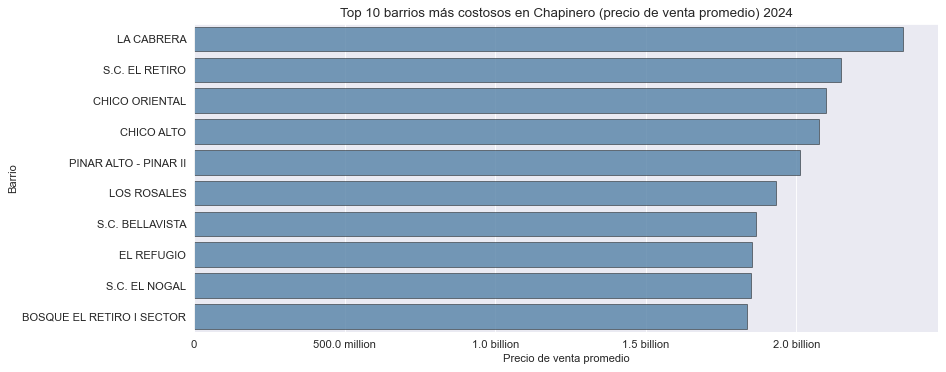

In [39]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_mean,
    y=top_barrios_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más costosos en Chapinero (precio de venta promedio) 2024')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))

plt.show()

In [40]:
top_barrios_median = top_barrios[top_barrios['count'] > 22].sort_values('median', ascending=False).head(10)
top_barrios_median.applymap(lambda x: humanize.intword(x))

count         mean       median            std
barrio                                                              
LA CABRERA              352  2.4 billion  2.2 billion  967.2 million
PINAR ALTO - PINAR II    30  2.0 billion  2.2 billion  803.1 million
S.C. EL RETIRO          160  2.1 billion  1.9 billion    1.0 billion
CHICO ALTO              105  2.1 billion  1.9 billion  784.3 million
CHICO ORIENTAL          160  2.1 billion  1.8 billion    1.1 billion
EL REFUGIO              254  1.9 billion  1.7 billion  858.2 million
LOS ROSALES             542  1.9 billion  1.7 billion  979.4 million
S.C. BELLAVISTA         465  1.9 billion  1.7 billion  895.9 million
S.C. EL NOGAL           274  1.9 billion  1.7 billion  879.7 million
ZAMUDIO                  46  1.5 billion  1.6 billion  805.3 million

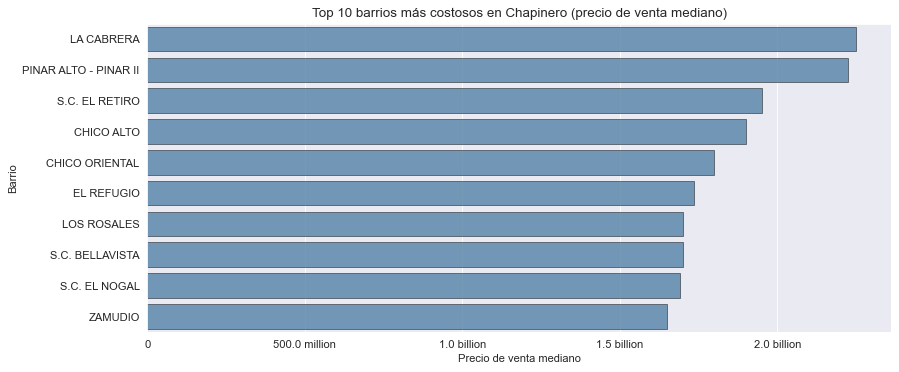

In [41]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_median,
    y=top_barrios_median.index,
    x='median',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más costosos en Chapinero (precio de venta mediano)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [42]:
top_barrios_economicos = chapinero.groupby('barrio').agg(
    count=('barrio', 'count'),
    mean=('precio_venta', 'mean'),
    median=('precio_venta', 'median'),
    std=('precio_venta', 'std'),
)

top_barrios_economicos_mean = top_barrios_economicos[top_barrios_economicos['count'] > 10].sort_values('mean', ascending=True).head(10)
top_barrios_economicos_mean.applymap(lambda x: humanize.intword(x))

count           mean         median            std
barrio                                                                   
S.C. CHAPINERO CENTRAL   104  373.1 million  335.5 million  161.0 million
S.C. SUCRE                37  404.4 million  366.0 million  141.6 million
S.C. MARLY                48  404.7 million  336.0 million  285.3 million
S.C. CHAPINERO NORTE      56  506.8 million  455.0 million  238.9 million
S.C. PARDO RUBIO          77  516.6 million  450.0 million  252.9 million
S.C INGEMAR               57  677.4 million  500.0 million  448.0 million
S.C. MARIA CRISTINA       50  700.0 million  592.5 million  415.2 million
S.C. LA SALLE             45  748.3 million  694.6 million  500.2 million
S.C. ESPARTILLAL          33  807.5 million  759.0 million  390.0 million
S.C. BOSQUE CALDERON      42  822.2 million  590.0 million  598.3 million

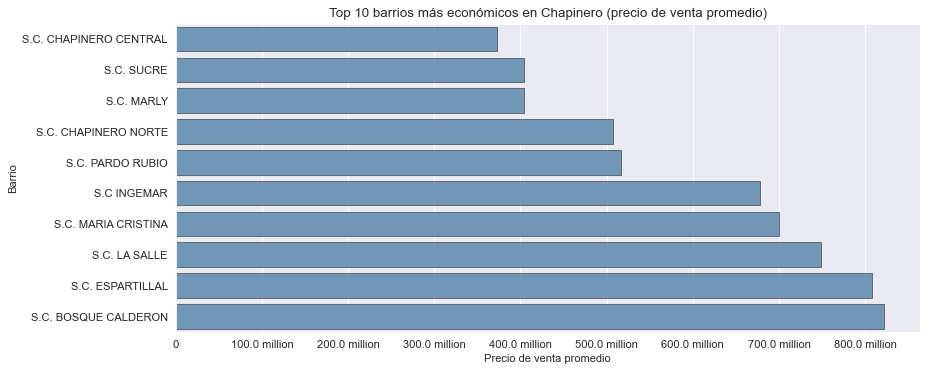

In [43]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_economicos_mean,
    y=top_barrios_economicos_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más económicos en Chapinero (precio de venta promedio)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))

plt.show()

In [44]:
top_barrios_economicos_median = top_barrios_economicos[top_barrios_economicos['count'] > 10].sort_values('median', ascending=True).head(10)
top_barrios_economicos_median.applymap(lambda x: humanize.intword(x))

count           mean         median            std
barrio                                                                   
S.C. CHAPINERO CENTRAL   104  373.1 million  335.5 million  161.0 million
S.C. MARLY                48  404.7 million  336.0 million  285.3 million
S.C. SUCRE                37  404.4 million  366.0 million  141.6 million
S.C. PARDO RUBIO          77  516.6 million  450.0 million  252.9 million
S.C. CHAPINERO NORTE      56  506.8 million  455.0 million  238.9 million
S.C INGEMAR               57  677.4 million  500.0 million  448.0 million
S.C. BOSQUE CALDERON      42  822.2 million  590.0 million  598.3 million
S.C. MARIA CRISTINA       50  700.0 million  592.5 million  415.2 million
S.C. LA SALLE             45  748.3 million  694.6 million  500.2 million
S.C. ESPARTILLAL          33  807.5 million  759.0 million  390.0 million

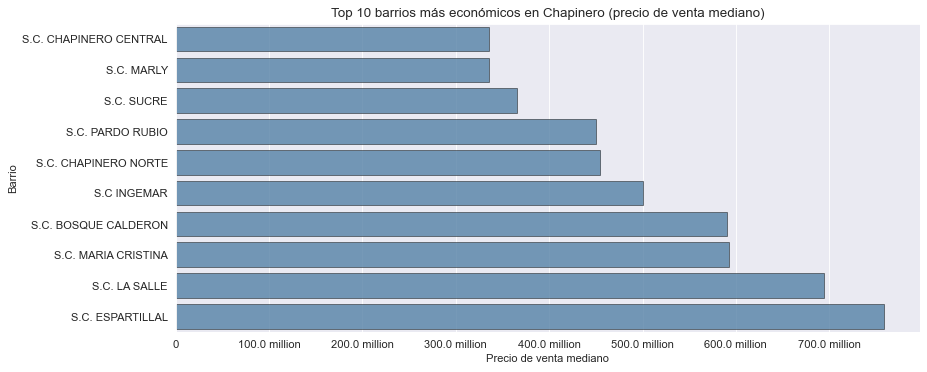

In [45]:
plt.figure(figsize=(12, 5))

sns.barplot(
    top_barrios_economicos_median,
    y=top_barrios_economicos_median.index,
    x='median',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Top 10 barrios más económicos en Chapinero (precio de venta mediano)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Barrio')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Cercania a Transmilenio

In [46]:
chapinero.groupby('is_cerca_estacion_tm')['precio_venta'].describe().applymap(lambda x: humanize.intcomma(x))

count                   mean                  std  \
is_cerca_estacion_tm                                                        
0                     5,424.0  1,719,880,989.3530605     971,878,794.5938   
1                     1,228.0  1,039,086,713.1514658  767,468,934.6228936   

                                min            25%              50%  \
is_cerca_estacion_tm                                                  
0                     180,000,000.0  950,000,000.0  1,500,000,000.0   
1                     155,000,000.0  530,000,000.0    800,000,000.0   

                                  75%              max  
is_cerca_estacion_tm                                    
0                     2,300,000,000.0  4,521,700,000.0  
1                     1,300,000,000.0  4,500,000,000.0

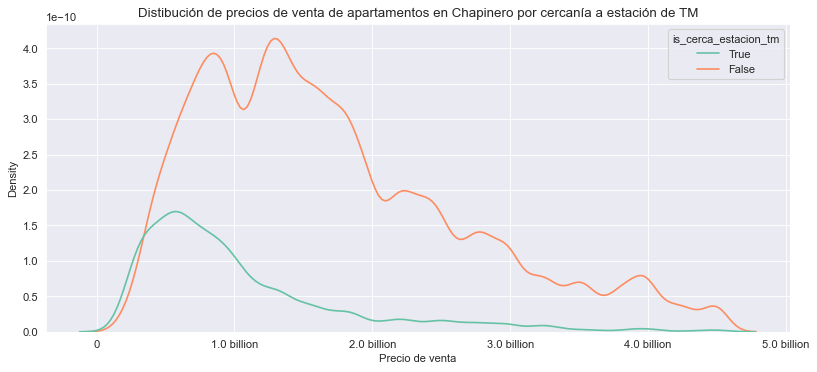

In [47]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='precio_venta',
    bw_adjust=.5,
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Chapinero por cercanía a estación de TM')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

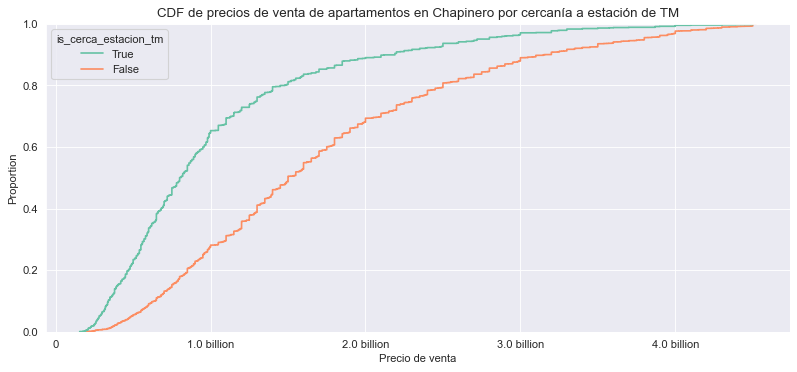

In [48]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='precio_venta',
    hue='is_cerca_estacion_tm',
    hue_order=[True, False],
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Chapinero por cercanía a estación de TM')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Estrato

In [49]:
chapinero.groupby('estrato')['precio_venta'].describe().applymap(lambda x: humanize.intword(x))

count           mean            std            min  \
estrato                                                              
0.0                 4    2.5 billion    1.3 billion  850.0 million   
1.0                12    2.2 billion  854.3 million    1.3 billion   
2.0                 7  810.1 million  749.0 million  240.0 million   
3.0               103  368.3 million  175.4 million  175.0 million   
4.0               528  682.3 million  548.9 million  155.0 million   
5.0               683    1.2 billion  727.9 million  270.0 million   
6.0      5.3 thousand    1.8 billion  958.7 million  208.0 million   

                   25%            50%            75%          max  
estrato                                                            
0.0        1.7 billion    2.6 billion    3.4 billion  3.8 billion  
1.0        1.5 billion    2.1 billion    2.4 billion  4.4 billion  
2.0      356.5 million  580.0 million  869.0 million  2.4 billion  
3.0      260.0 million  330.0 million  435.0 million  1.5 billion  
4.0      366.0 million  500.0 million  742.5 million  4.1 billion  
5.0      640.0 million  950.0 million    1.5 billion  4.5 billion  
6.0      990.0 million    1.6 billion    2.3 billion  4.5 billion

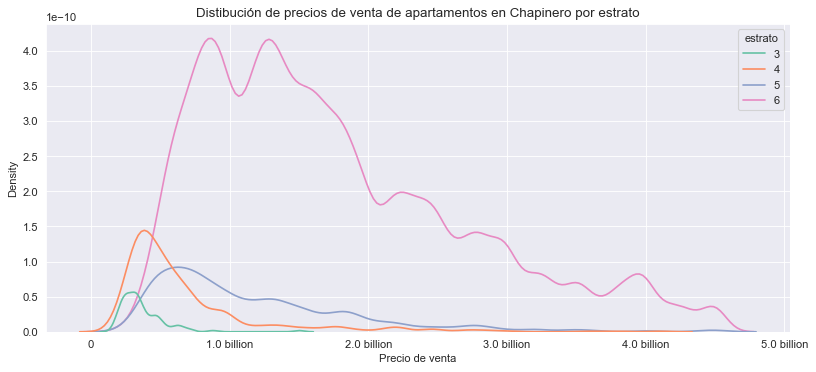

In [50]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='precio_venta',
    bw_adjust=.5,
    hue='estrato',
    hue_order=[3, 4, 5, 6],
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Chapinero por estrato')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

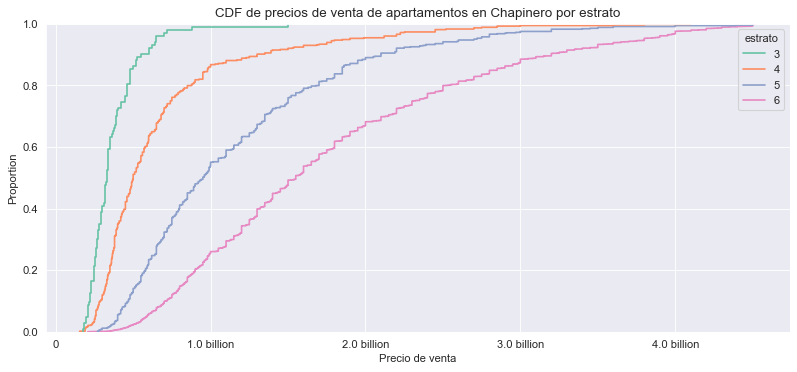

In [51]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='precio_venta',
    hue='estrato',
    hue_order=[3, 4, 5, 6],
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Chapinero por estrato')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

In [52]:
chapinero.columns

Index(['codigo', 'tipo_propiedad', 'tipo_operacion', 'precio_venta', 'area',
       'habitaciones', 'banos', 'administracion', 'parqueaderos', 'sector',
       'estrato', 'antiguedad', 'latitud', 'longitud', 'direccion',
       'descripcion', 'website', 'last_view', 'datetime', 'url', 'timeline',
       'estado', 'compañia', 'precio_arriendo', 'jacuzzi', 'piso', 'closets',
       'chimenea', 'permite_mascotas', 'gimnasio', 'ascensor',
       'conjunto_cerrado', 'piscina', 'salon_comunal', 'terraza', 'vigilancia',
       'coords_modified', 'localidad', 'barrio', 'estacion_tm_cercana',
       'distancia_estacion_tm_m', 'is_cerca_estacion_tm', 'parque_cercano',
       'distancia_parque_m', 'is_cerca_parque', 'last_viewed'],
      dtype='object')

### Antiguedad del apartamento

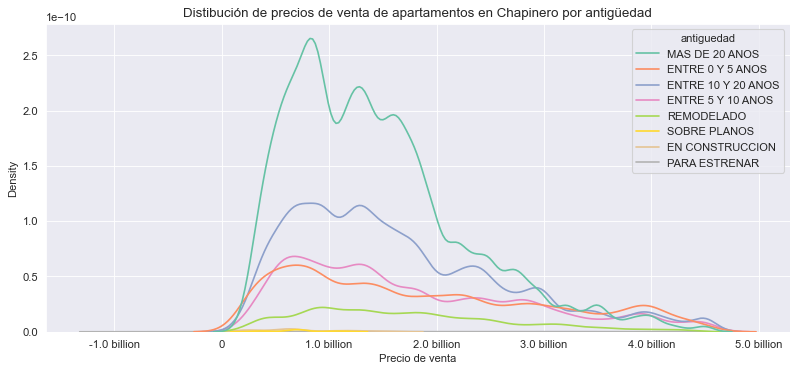

In [53]:
plt.figure(figsize=(12, 5))

sns.kdeplot(
    chapinero,
    x='precio_venta',
    bw_adjust=.5,
    hue='antiguedad',
    palette='Set2',
)

plt.title('Distibución de precios de venta de apartamentos en Chapinero por antigüedad')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

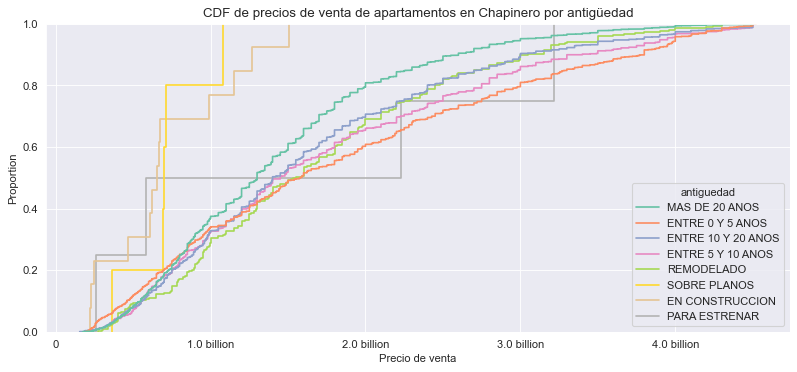

In [54]:
plt.figure(figsize=(12, 5))

sns.ecdfplot(
    chapinero,
    x='precio_venta',
    hue='antiguedad',
    palette='Set2',
)

plt.title('CDF de precios de venta de apartamentos en Chapinero por antigüedad')
plt.xlabel('Precio de venta')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Estacion de TM Cercana

In [55]:
estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('mean', ascending=False).applymap(lambda x: humanize.intword(x))

count           mean            std  \
estacion_tm_cercana                                                  
Héroes                            25    1.7 billion    1.2 billion   
Virrey                           266    1.4 billion  866.4 million   
Calle 85                         273    1.3 billion  743.4 million   
Calle 100 - Marketmedios         351  978.6 million  610.5 million   
Calle 76 - San Felipe             26  837.9 million  722.5 million   
Calle 72                          18  631.6 million  267.6 million   
Flores – Areandina                27  536.0 million  239.1 million   
Marly                             53  455.1 million  282.4 million   
Calle 63                          60  408.6 million  165.8 million   
AV. 39                            19  394.1 million  123.1 million   
Calle 45 - American School Way    45  386.1 million  145.3 million   
Calle 57                          65  382.5 million  170.2 million   

                                          min            25%            50%  \
estacion_tm_cercana                                                           
Héroes                          351.0 million  790.0 million    1.1 billion   
Virrey                          350.0 million  750.0 million  990.0 million   
Calle 85                        390.0 million  750.0 million    1.2 billion   
Calle 100 - Marketmedios        227.5 million  600.0 million  850.0 million   
Calle 76 - San Felipe           280.0 million  390.0 million  595.0 million   
Calle 72                        320.0 million  460.0 million  540.0 million   
Flores – Areandina              222.3 million  352.5 million  520.0 million   
Marly                           155.0 million  315.0 million  380.0 million   
Calle 63                        185.0 million  280.0 million  384.5 million   
AV. 39                          275.0 million  322.5 million  366.0 million   
Calle 45 - American School Way  190.0 million  280.0 million  355.0 million   
Calle 57                        175.0 million  275.0 million  349.0 million   

                                          75%            max  
estacion_tm_cercana                                           
Héroes                            2.4 billion    4.1 billion  
Virrey                            2.1 billion    4.4 billion  
Calle 85                          1.7 billion    4.5 billion  
Calle 100 - Marketmedios          1.1 billion    4.5 billion  
Calle 76 - San Felipe           870.0 million    2.9 billion  
Calle 72                        815.0 million    1.4 billion  
Flores – Areandina              650.0 million    1.4 billion  
Marly                           510.0 million    2.1 billion  
Calle 63                        477.5 million  900.0 million  
AV. 39                          373.0 million  685.0 million  
Calle 45 - American School Way  460.0 million  750.0 million  
Calle 57                        420.0 million    1.4 billion

In [56]:
estacion_tm_cercana_stats_mean = estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('mean', ascending=False)
estacion_tm_cercana_stats_median = estacion_tm_cercana.groupby('estacion_tm_cercana')['precio_venta'].describe().sort_values('50%', ascending=False)

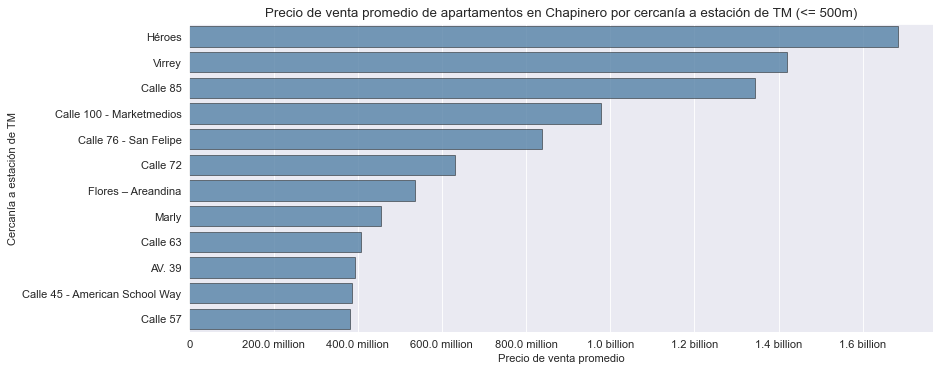

In [57]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats_mean,
    y=estacion_tm_cercana_stats_mean.index,
    x='mean',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta promedio de apartamentos en Chapinero por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

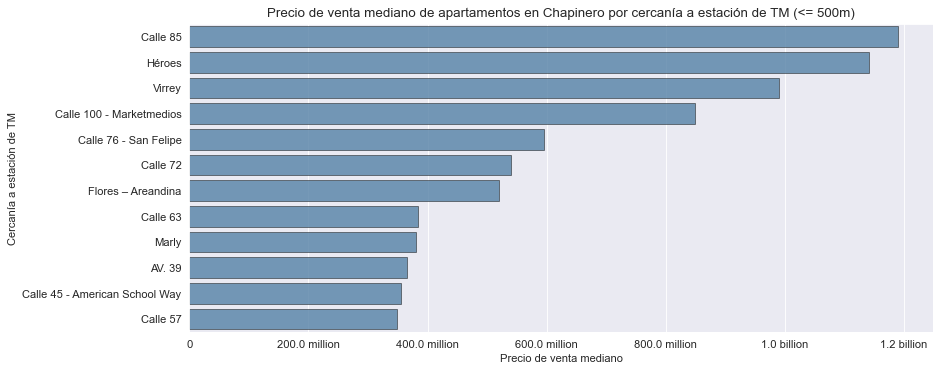

In [58]:
plt.figure(figsize=(12, 5))

sns.barplot(
    estacion_tm_cercana_stats_median,
    y=estacion_tm_cercana_stats_median.index,
    x='50%',
    color='steelblue',
    # palette='Set1',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta mediano de apartamentos en Chapinero por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta mediano')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

<Figure size 960x400 with 0 Axes>

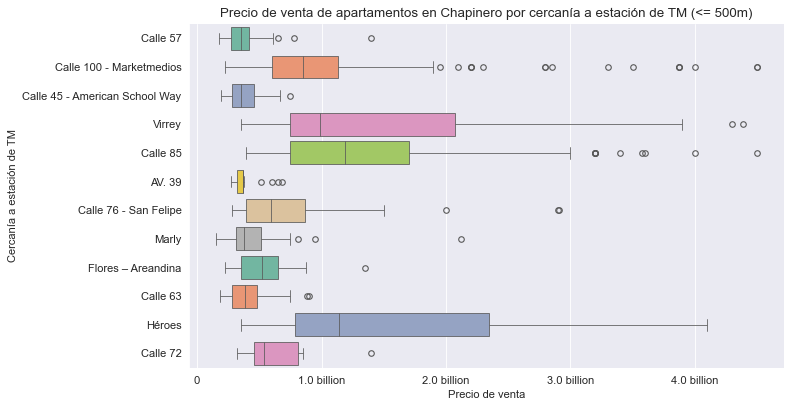

In [59]:
plt.figure(figsize=(12, 5))

sns.catplot(
    data=estacion_tm_cercana,
    x='precio_venta',
    y='estacion_tm_cercana',
    kind='box',
    height=5,
    aspect=2,
    palette='Set2',
    orient='h',
    linewidth=.7,
)

plt.title('Precio de venta de apartamentos en Chapinero por cercanía a estación de TM (<= 500m)')
plt.xlabel('Precio de venta')
plt.ylabel('Cercanía a estación de TM')
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(format_tick_humanize))
plt.show()

### Precios Anteriores Vs Actuales

## Antiguedad

In [60]:
chapinero.antiguedad.value_counts()

antiguedad
MAS DE 20 ANOS        2828
ENTRE 10 Y 20 ANOS    1619
ENTRE 5 Y 10 ANOS      945
ENTRE 0 Y 5 ANOS       930
REMODELADO             303
EN CONSTRUCCION         13
SOBRE PLANOS             5
PARA ESTRENAR            4
Name: count, dtype: int64

In [70]:
plt.figure(figsize=(12, 5))

sns.countplot(
    chapinero,
    x='antiguedad',
    order=chapinero.antiguedad.value_counts().index,
    palette='Set2',
    # edgecolor='black',
    # linewidth=.5,
    alpha=.8,
)

plt.title('Cantidad de apartamentos en Chapinero por antigüedad')
plt.xlabel('Antigüedad')
plt.ylabel('Cantidad')
plt.xticks(rotation=80)
plt.show()

### Barrios

In [71]:
chapinero.groupby('antiguedad')['barrio'].describe()

count unique                          top freq
antiguedad                                                       
EN CONSTRUCCION       13      2         S.C. ANTIGUO COUNTRY   10
ENTRE 0 Y 5 ANOS     930     49                S.C. EL CHICO  128
ENTRE 10 Y 20 ANOS  1619     61             S.C. CHICO NORTE  207
ENTRE 5 Y 10 ANOS    945     56             S.C. CHICO NORTE  174
MAS DE 20 ANOS      2828     65  S.C. CHICO NORTE III SECTOR  310
PARA ESTRENAR          4      2                   EL REFUGIO    2
REMODELADO           303     38             S.C. CHICO NORTE   37
SOBRE PLANOS           5      1                S.C. LA SALLE    5

In [63]:
chapinero.groupby('antiguedad')['area'].describe().apply(lambda x: round(x,1))

count   mean    std   min    25%    50%    75%    max
antiguedad                                                                
EN CONSTRUCCION       13.0   42.8   20.8  21.3   27.4   35.8   55.5   88.4
ENTRE 0 Y 5 ANOS     930.0  143.2   79.3  13.0   77.0  138.5  203.8  393.0
ENTRE 10 Y 20 ANOS  1619.0  178.6   90.3   1.0  108.0  166.0  242.0  441.0
ENTRE 5 Y 10 ANOS    945.0  166.3   86.5  20.0   95.0  155.0  228.0  444.0
MAS DE 20 ANOS      2828.0  194.7   88.3  10.0  128.0  184.0  251.5  441.0
PARA ESTRENAR          4.0  129.7  104.3  27.4   49.6  123.3  203.4  244.9
REMODELADO           303.0  203.4   94.8  39.0  136.6  195.0  265.5  440.0
SOBRE PLANOS           5.0   61.2   20.7  30.3   62.4   62.4   62.4   88.6

In [64]:
chapinero.groupby('barrio')['antiguedad'].describe().sort_values(by='count', ascending=False).head(10)

count unique                 top freq
barrio                                                           
S.C. CHICO NORTE              795      5      MAS DE 20 ANOS  250
S.C. EL CHICO                 657      5      MAS DE 20 ANOS  219
S.C. CHICO NORTE III SECTOR   614      5      MAS DE 20 ANOS  310
LOS ROSALES                   542      5      MAS DE 20 ANOS  260
S.C. BELLAVISTA               465      5      MAS DE 20 ANOS  246
LA CABRERA                    352      5      MAS DE 20 ANOS  172
S.C. ANTIGUO COUNTRY          329      6    ENTRE 0 Y 5 ANOS  103
S.C. EL NOGAL                 274      5      MAS DE 20 ANOS  147
EL REFUGIO                    254      6      MAS DE 20 ANOS   88
CHICO RESERVADO               254      5  ENTRE 10 Y 20 ANOS  106

### Estrato

## Barrios

In [65]:
chapinero.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10)

codigo
barrio                             
S.C. CHICO NORTE                795
S.C. EL CHICO                   658
S.C. CHICO NORTE III SECTOR     614
LOS ROSALES                     542
S.C. BELLAVISTA                 465
LA CABRERA                      352
S.C. ANTIGUO COUNTRY            329
S.C. EL NOGAL                   274
CHICO RESERVADO                 256
EL REFUGIO                      254

In [66]:
plt.figure(figsize=(12, 5))

sns.barplot(
    data=chapinero.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10),
    x='codigo',
    y=chapinero.groupby('barrio')['codigo'].count().sort_values(ascending=False).to_frame().head(10).index,
    # palette='Set2',
    color='steelblue',
    orient='h',
    edgecolor='black',
    linewidth=.4,
    alpha=.8
)

plt.title('Top 10 barrios con más inmuebles en venta en Chapinero')
plt.xlabel('Cantidad de inmuebles')
plt.ylabel('Barrio')
plt.show()

In [73]:
# apartamentos mas costoso por parque cercano
chapinero.groupby('parque_cercano')['precio_venta'].describe().applymap(lambda x: humanize.intword(x))
parque_cercano_stats = chapinero.groupby('parque_cercano')['precio_venta'].describe().sort_values('mean', ascending=False)
parque_cercano_stats

count          mean  \
parque_cercano                                                             
PARQUE VECINAL URBANIZACIÓN LA CABRERA              1847.0  1.994975e+09   
PARQUE ZONAL SAN ANDRÉS                             1271.0  1.974187e+09   
PARQUE ZONAL GUSTAVO URIBE BOTERO                   1536.0  1.399198e+09   
PARQUE ZONAL CANAL EL VIRREY EL CHICO                700.0  1.393758e+09   
PARQUE METROPOLITANO RECONCILIACIÓN                  227.0  1.230309e+09   
PARQUE VECINAL URBANIZACIÓN NORMANDIA I II II Y...   831.0  1.061570e+09   
PARQUE ZONAL LA ESTACIÓN                              29.0  5.844138e+08   
PARQUE METROPOLITANO PARQUE NACIONAL (PM2A) ENR...   191.0  5.177831e+08   
PARQUE ESCENARIO DEPORTIVO EL CAMPINCITO - CEAD       16.0  4.506250e+08   
PARQUE ZONAL GIMNASIO DEL NORTE                        4.0  3.562500e+08   

                                                             std          min  \
parque_cercano                                                                  
PARQUE VECINAL URBANIZACIÓN LA CABRERA              9.794653e+08  305000000.0   
PARQUE ZONAL SAN ANDRÉS                             9.956573e+08  208000000.0   
PARQUE ZONAL GUSTAVO URIBE BOTERO                   8.971773e+08  175000000.0   
PARQUE ZONAL CANAL EL VIRREY EL CHICO               7.863889e+08  220000000.0   
PARQUE METROPOLITANO RECONCILIACIÓN                 7.212180e+08  351000000.0   
PARQUE VECINAL URBANIZACIÓN NORMANDIA I II II Y...  6.575334e+08  227500000.0   
PARQUE ZONAL LA ESTACIÓN                            2.594575e+08  300000000.0   
PARQUE METROPOLITANO PARQUE NACIONAL (PM2A) ENR...  3.362397e+08  155000000.0   
PARQUE ESCENARIO DEPORTIVO EL CAMPINCITO - CEAD     2.646247e+08  250000000.0   
PARQUE ZONAL GIMNASIO DEL NORTE                     7.272952e+07  290000000.0   

                                                             25%  \
parque_cercano                                                     
PARQUE VECINAL URBANIZACIÓN LA CABRERA              1.250000e+09   
PARQUE ZONAL SAN ANDRÉS                             1.255000e+09   
PARQUE ZONAL GUSTAVO URIBE BOTERO                   6.600000e+08   
PARQUE ZONAL CANAL EL VIRREY EL CHICO               8.300000e+08   
PARQUE METROPOLITANO RECONCILIACIÓN                 6.910000e+08   
PARQUE VECINAL URBANIZACIÓN NORMANDIA I II II Y...  6.565000e+08   
PARQUE ZONAL LA ESTACIÓN                            4.200000e+08   
PARQUE METROPOLITANO PARQUE NACIONAL (PM2A) ENR...  3.220000e+08   
PARQUE ESCENARIO DEPORTIVO EL CAMPINCITO - CEAD     3.487500e+08   
PARQUE ZONAL GIMNASIO DEL NORTE                     3.237500e+08   

                                                             50%  \
parque_cercano                                                     
PARQUE VECINAL URBANIZACIÓN LA CABRERA              1.800000e+09   
PARQUE ZONAL SAN ANDRÉS                             1.720000e+09   
PARQUE ZONAL GUSTAVO URIBE BOTERO                   1.290000e+09   
PARQUE ZONAL CANAL EL VIRREY EL CHICO               1.170000e+09   
PARQUE METROPOLITANO RECONCILIACIÓN                 1.000000e+09   
PARQUE VECINAL URBANIZACIÓN NORMANDIA I II II Y...  8.700000e+08   
PARQUE ZONAL LA ESTACIÓN                            5.200000e+08   
PARQUE METROPOLITANO PARQUE NACIONAL (PM2A) ENR...  3.900000e+08   
PARQUE ESCENARIO DEPORTIVO EL CAMPINCITO - CEAD     3.800000e+08   
PARQUE ZONAL GIMNASIO DEL NORTE                     3.375000e+08   

                                                             75%           max  
parque_cercano                                                                  
PARQUE VECINAL URBANIZACIÓN LA CABRERA              2.600000e+09  4.521700e+09  
PARQUE ZONAL SAN ANDRÉS                             2.600000e+09  4.500000e+09  
PARQUE ZONAL GUSTAVO URIBE BOTERO                   1.850000e+09  4.500000e+09  
PARQUE ZONAL CANAL EL VIRREY EL CHICO               1.700000e+09  4.300000e+09  
PARQUE METROPOLITANO RECONCILIACIÓN            

In [78]:
sns.boxplot(
    data=chapinero,
    x='precio_venta',
    y='parque_cercano',
    palette='Set2',
)

plt.title('Precio de venta de apartamentos en Chapinero por cercanía a parque (<= 500m) 2024')

Text(0.5, 1.0, 'Precio de venta de apartamentos en Chapinero por cercanía a parque (<= 500m) 2024')

In [79]:
sns.barplot(
    parque_cercano_stats,
    y=parque_cercano_stats.index,
    x='mean',
    color='steelblue',
    edgecolor='black',
    linewidth=.5,
    alpha=.8,
)

plt.title('Precio de venta promedio de apartamentos en Chapinero por cercanía a parque (<= 500m) 2024')
plt.xlabel('Precio de venta promedio')
plt.ylabel('Cercanía a parque')
plt.show()